In [4]:
# from pyeeg.connectivity import phase_transfer_entropy
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as sig

/home/hugo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/hugo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/hugo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
fs = 100
t = np.arange(0, 10, 1/fs)
x = np.random.randn(len(t), 1)
low_pass = sig.firwin(101, 10, fs=fs) # 10 Hz low pass filter
x = sig.filtfilt(low_pass, 1, x, axis=0)

In [10]:
plt.style.use('my_dark')

(0, 50)

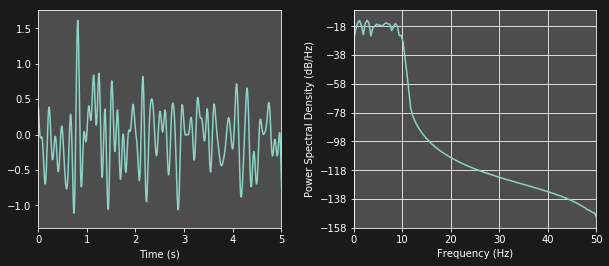

In [15]:
f, ax = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={'wspace': 0.3})
ax[0].plot(t, x)
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim([0, 5])

ax[1].psd(x.squeeze(), Fs=fs) # power spectral density
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xlim([0, 50])

In [16]:
phi_x = np.angle(sig.hilbert(x, axis=0)) # between -pi and pi

(0, 5)

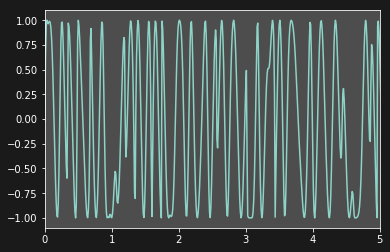

In [19]:
plt.plot(t, np.sin(phi_x))
plt.xlim([0, 5])

## Granger Causality

Focusing on:
1. Granger causality defined from autoregressive methods (see [Cohen's video](https://www.youtube.com/watch?v=XqsSB_vpHLs))
2. Compared to spectral measures such as magnitude coherence between both signals

First I need to produce two signals from a VAR model:
- I will either generate one $X\approx$ AR(2)/ or $\approx \mathcal{N}(0, 1)$ signal, and bind a second signal to it such as e.g. $Y(t) = 1.2 X(t-1) - 0.9 X(t-2)$
- or directly generate a _pair_ of signals with a VAR(2) model

Given the univariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + e_{x}(t)
$$
And the bivariate process:
$$
x(t) = a_1 x(t-1) + a_2 x(t-2) + \cdots + b_1 y(t-1) + b_2 y(t-2) + \cdots +  \epsilon_{xy}(t)
$$

We can get the granger causality measure as:
$$
GC = log(\frac{var(e)}{var(\epsilon)})
$$

(0, 5)

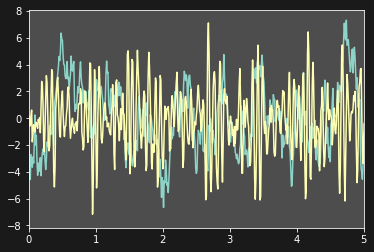

In [60]:
def simulate_ar(order, a, n, sigma=1):
    x = np.zeros(n + order)
    for i in range(n):
        if i < order:
            x[i] = np.random.randn()* sigma
        else:
            x[i] = np.dot(a[::-1], x[i-order:i]) + np.random.randn()*sigma
    return x[order:]

# Example
order = 1
a = np.array([0.9])
n = len(t)
x1 = simulate_ar(order, a, n)
order = 2
a = np.array([1.2, -0.8])
x2 = simulate_ar(order, a, n)
plt.plot(t, x1)
plt.plot(t, x2)
plt.xlim([0, 5])

In [70]:
x = x2
y = np.random.randn(len(t),)
a = [1.2, -0.8]
for k, aa in enumerate(a):
    y[k+1:] += aa * x[:-k-1] # x[t-k-1]

In [83]:
model.

Object `model.error` not found.


In [20]:
import statsmodels.tsa.api as smt

# Define parameters
nobs = 1000
order = 1
coef = np.array([0.8, -0.4])

# Function to simulate VAR model
def simulate_var(order, coef, nobs):
    np.random.seed(42)
    data = np.random.normal(size=(nobs, 2))
    for t in range(order, nobs):
        data[t] = coef * data[t-order] + np.random.normal(size=2)
    return data

# Generate data
data = simulate_var(order, coef, nobs)

# Fit VAR model
model = smt.VAR(data)
results = model.fit(maxlags=order)

# Print model summary
print(results.summary())


/home/hugo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/hugo/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Nov, 2023
Time:                     15:37:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0534220
Nobs:                     999.000    HQIC:                 0.0351532
Log likelihood:          -2841.00    FPE:                    1.02424
AIC:                    0.0239520    Det(Omega_mle):         1.01812
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const        -0.011828         0.031830           -0.372           0.710
L1.y1         0.817941         0.018349           44.577           0.000
L1.y2        -0.058872         0.028664           -2.054           0.040

Results for equation 

In [101]:
results.coefs # coefs
results.resid_acov(2)
results.resid.shape # residual for each time series (epsilon as we doing a multivariate regression)

(999, 2)

In [93]:
results.test_causality(0, 1, kind='f')
print(granger_test)

<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y1 does not Granger-cause y2: fail to reject at 5% significance level. Test statistic: 0.046, critical value: 3.846>, p-value: 0.831>


<statsmodels.tsa.vector_ar.hypothesis_test_results.CausalityTestResults object. H_0: y1 does not Granger-cause y2: fail to reject at 5% significance level. Test statistic: 0.046, critical value: 3.846>, p-value: 0.831>


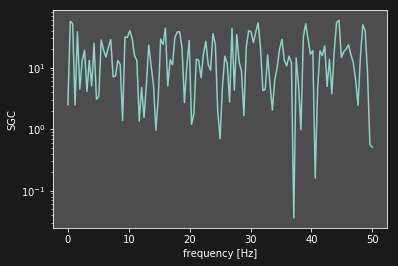

In [30]:

# Assume data is your two-dimensional time series data
model = smt.VAR(data)
results = model.fit(maxlags=1)

# Test for Granger Causality
# granger_test = results.test_causality('y', 'x', kind='f')
granger_test = results.test_causality(1, 0, kind='f')
print(granger_test)

# Assume x and y are your time series data
x, y = data.T
# f, Pxx = sig.periodogram(x)
f, Pxx = sig.csd(x, x, fs=fs)
# _, Pyy = sig.periodogram(y)
_, Pyy = sig.csd(y, y)
_, Pxy = sig.csd(x, y)

# Compute spectral Granger causality
SGC = np.abs(Pxy)**2 / (Pxx * Pyy)

# Plot spectral Granger causality
plt.semilogy(f, SGC)
plt.xlabel('frequency [Hz]')
plt.ylabel('SGC')
plt.show()